# Pyrocko Notebook
## Double Couple Waveform Inversion (The 2009 Aquila Earthquake)

In this Jupyter-notebook we look at teleseismic waveforms of the 2009 Aquila Earthquake and setup `pyrocko.gf` forward modelling to invert for the double couple mechanism of the event. We will use `pyrocko` to handle the seismic data and execute the forward modelling based on pre-calculated Green's function stores, `scipy` delivers the optimisation algorithms.
Besides this Notebook you will also need to download the utils_nb.py file from this repository.

_Authors:_
Andreas Steinberg, Marius Isken

-Nov. 2017

In [1]:
%matplotlib notebook
import time
import os
import scipy
import numpy as num
import matplotlib.pyplot as plt
import plotly.plotly as py
from collections import OrderedDict

import utils_nb

from pyrocko import gf, trace
from pyrocko import moment_tensor as mtm
from pyrocko.gf import ws, LocalEngine, Target, DCSource
from pyrocko import util, pile, model, config, trace, io, pile, catalog

km = 1000.

### Optimisation Parameters
Setup of the optimisation parameters, as well as boundaries for the source parameters.

In [2]:
component = 'Z'
f_low = 0.05  # Hz, for a lowpass filter
taper = trace.CosFader(xfade=2.0)  # Cosine taper, 2s fade

phase = 'P' # Phase to fit
tmin_fit = 15. # [s] to fit before synthetic phase onset (from GFStore)
tmax_fit = 35. # [s] ... after

bounds = OrderedDict([
    ('north_shift', (-20.*km, 20.*km)),
    ('east_shift', (-20.*km, 20.*km)),
    ('depth', (3.*km, 8.*km)),
    ('magnitude', (6.2, 6.4)),
    ('strike', (100., 140.)),
    ('dip', (40., 60.)),
    ('rake', (-100, -150.)),
    ('timeshift', (-20., 20.)),
    ])

### Load the Waveforms
We download the instrument-corrected seismic waveforms and use a `pyrocko.pile` to manage the data.

In [3]:
# Download the instrument-corrected 2009 Aquila Earthquake data
data_path = utils_nb.download_dir('aquila_realdata/')
data = pile.make_pile([data_path])
traces = data.all()  # retrieves the raw waveform data as a 2D `numpy.array`.

for tr in traces:
    tr.lowpass(4, f_low)

selecting files... done. 58 files selected.
Looking at files [------------------------------------------------------] 100% 
Scanning files [--------------------------------------------------------] 100% 
Cannot read file '/media/asteinbe/data/asteinbe/trystuff/pyrocko-notebooks/data/aquila_realdata/stations_short.txt': No SEED data detected (file: /media/asteinbe/data/asteinbe/trystuff/pyrocko-notebooks/data/aquila_realdata/stations_short.txt)
The following file caused problems and will be ignored:
/media/asteinbe/data/asteinbe/trystuff/pyrocko-notebooks/data/aquila_realdata/stations_short.txt


### Initialize Forward Modelling Engine (Seismosizer)
We download the precalculated Green's function database (`Store`) *global_2s_25km* from http://kinherd.org

In [4]:
store_id = 'global_2s_25km'
if not os.path.exists(store_id):
    ws.download_gf_store(site='kinherd', store_id=store_id)

Now we fire up the `engine` to forward model synthetic seismograms on our _global_2s_25km_ GF database.

In [5]:
engine = gf.LocalEngine(store_superdirs=['.']) # The Path to where the gf_store(s)
store = engine.get_store(store_id)  # Load the store.

### Get GlobalCMT Start Model
We use the GlobalCMT catalog to search for the 2009 Aquila Earthquake and initalize a source for the starting model.

In [6]:
tmin = util.str_to_time('2009-04-06 00:00:00')  # beginning time of query
tmax = util.str_to_time('2009-04-06 05:59:59')  # ending time of query
event = catalog.GlobalCMT().get_events(
    time_range=(tmin, tmax),
    magmin=6.)[0]

base_source = gf.MTSource.from_pyrocko_event(event)

### Station and _Target_ Setup
We use the term _Target_ for a single component of a single station.

In [7]:
stations_list = model.load_stations('data/aquila_realdata/stations_short.txt')
for s in stations_list:
    s.set_channels_by_name(*component.split())

Next we define the `Target` - where to calculate the synthetic seismogram.

In [8]:
targets=[]
for s in stations_list:
    target = Target(
            lat=s.lat,
            lon=s.lon,
            store_id=store_id,   # The gf-store to be used for this target,
            interpolation='multilinear',  # Interpolation method between GFStore nodes
            quantity='displacement',
            codes=s.nsl() + ('BH' + component,))
    targets.append(target)

### Objective Function
Now the objective function that will be called by `scipy.optimize`:

In [9]:
source = gf.DCSource(
    lat=event.lat,
    lon=event.lon)

def update_source(params):
    s = source
    s.north_shift = float(params[0])
    s.east_shift = float(params[1])
    s.depth = float(params[2])
    s.magnitude = float(params[3])
    s.strike = float(params[4])
    s.dip = float(params[5])
    s.rake = float(params[6])
    s.time = float(event.time - params[7])
    return source

def process_trace(trace, tmin, tmax, lowpass=False, inplace=True):
    if lowpass:
        trace.lowpass(4, f_low)
    trace = trace.chop(tmin, tmax, inplace=inplace)
    trace.taper(taper)
    return trace

iiter = 0

def trace_fit(params, line=None):
    global iiter
    update_source(params)

    # Forward model synthetic seismograms
    response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()

    misfits = 0.
    norms = 0.

    for obs, syn, target in zip(traces, syn_traces, targets):
        syn_phs = store.t(phase, base_source, target)
        
        tmin = base_source.time + syn_phs - tmin_fit  # start before theor. arrival
        tmax = base_source.time + syn_phs + tmax_fit  # end after theor. arrival
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=True)

        misfits += num.sqrt(num.sum((obs.ydata - syn.ydata)**2))
        norms += num.sqrt(num.sum(obs.ydata**2))
    
    misfit = num.sqrt(misfits**2 / norms**2)
    
    iiter += 1

    if line:
        data = {
            'y': [misfit],
            'x': [iiter],
        }
        line.data_source.stream(data)

    return misfit

### Optimisation with SciPy
We will use `scipy.optimize.differential_evolution` to find a best fitting model. The method is stochastic in nature (does not use gradient methods) to find the minimium, and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient based techniques. The scipy solver can easily be exchanged for a method of your favor. If you just want a quick demonstration, you can change the number of maxiter in the solve function to something lower.

In [10]:
def solve():
    t = time.time()

    result = scipy.optimize.differential_evolution(
        trace_fit,
        args=[p],
        bounds=tuple(bounds.values()),
        maxiter=15000,
        tol=0.01,
        callback=update_plot)

    source = update_source(result.x)
    source.regularize()

    print("Time elapsed: %.1f s" % (time.time() - t))
    print("Best model:\n - Misfit %f" % trace_fit(result.x))
    print(source)
    return result, source

#### Running the optimization and plotting of the Convergence
For plotting we use bokeh (which you might need to install)

In [12]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

f = figure(title='SciPy Optimisation Progress',
           x_axis_label='# Iteration',
           y_axis_label='Misfit',
           plot_width=800,
           plot_height=300)
p = f.scatter([], [])
show(f, notebook_handle=True)

def update_plot(*a, **ka):
    push_notebook()

# Start the optimisation
result, best_source = solve()

Loading BokehJS ...

Time elapsed: 112.5 s
Best model:
 - Misfit 1.255760
--- !pf.DCSource
lat: 42.29
lon: 13.35
north_shift: 7133.841195788899
east_shift: 7690.721161726071
elevation: 0.0
depth: 3063.7232231645157
time: 2009-04-06 01:32:29.297190
stf_mode: post
magnitude: 6.214677659485893
strike: 134.6072161989871
dip: 51.665046373603204
rake: -143.50897602844884



### Plot the Results
Now we plot the synthetic waveforms produced by our the best model vs. the observed traces.

In [13]:
def plot_traces(result):
    nstations = len(stations_list)
    response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()

    fig, axes = plt.subplots(nstations, squeeze=True, sharex=True)
    fig.subplots_adjust(hspace=0)
    plt.setp([ax.get_xticklabels() for ax in axes[:-1]], visible=False)

    for istation, (obs, syn, target) in enumerate(zip(traces, syn_traces, targets)):
        ax = axes[istation]
        tp = store.t(phase, base_source, target)
        tp_onset = base_source.time + tp
        tmin = tp_onset - tmin_fit
        tmax = tp_onset + tmax_fit
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)
        
        s1 = ax.plot(obs.get_xdata(), obs.ydata, color='b')
        s2 = ax.plot(syn.get_xdata(), syn.ydata, color='r')
        s3 = ax.plot([tp_onset, tp_onset], [tr.ydata.min(), tr.ydata.max()], 'k-', lw=2)

        ax.text(-.2, 0.5, stations_list[istation].station,
                transform=ax.transAxes)
        ax.set_yticklabels([], visible=False)

    axes[-1].set_xlabel('Time [s]')
    plt.suptitle('Waveform fits for %s-Phase and component %s' % (phase, component))
    plt.legend(
        (s1[0], s2[0], s3[0]),
        ('Data', 'Synthetic','%s Phase-onset' % phase),
        loc='upper center',
        bbox_to_anchor=(0.5, -2.),
        fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [20]:
def plot_snuffler(result, source):
    engine = gf.get_engine()
    response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()
    obs_traces = []
    
    for obs, syn, target in zip(traces, syn_traces, targets):
        tp = store.t('P', base_source, target)
        tmin = base_source.time + tp - tmin_fit
        tmax = base_source.time + tp + tmax_fit

        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)

        obs_traces.append(obs)

    trace.snuffle(obs_traces + syn_traces, stations=stations_list, events= [event])

Next we plot the station distribution with folium (which you might need to install)

In [16]:
def plot_stations():
    import folium
    fmap = folium.Map(
        location=[best_source.lat, best_source.lon],
        tiles='Stamen Terrain',
        zoom_start=3)
    folium.Marker([best_source.lat, best_source.lon],
        popup=('2009 Aquila Earthquake'),
        icon=folium.Icon(color='red', icon='info-sign')).add_to(fmap)
                  
    for s in stations_list:
        folium.Marker([s.lat, s.lon],
                      popup='<b>%s</b></h4>' % s.station).add_to(fmap)
    fmap.add_child(folium.LatLngPopup())
    return fmap
    
plot_stations()

<IPython.core.display.Javascript object>


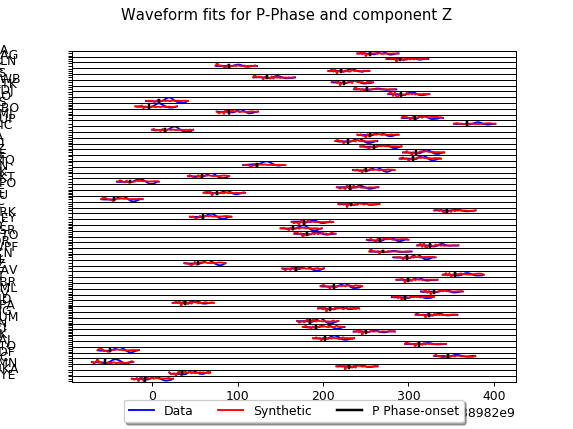

In [17]:
plot_traces(result)

Alternatively we can plot using snuffler, which will open in a seperate window.

In [21]:
plot_snuffler(result, best_source)

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/pyrocko/gui/snuffling.py", line 1695, in load_if_needed
    self._module = __import__(self._name)
  File "/home/asteinbe/.snufflings/audio.py", line 16, in <module>
    from PyQt4.phonon import Phonon
RuntimeError: the PyQt4.QtCore and PyQt5.QtCore modules both wrap the QObject class

Snuffling module "/home/asteinbe/.snufflings/audio.py" is broken
cc.py:pyrocko.gui.snuffling - ERROR    - Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/pyrocko/gui/snuffling.py", line 1695, in load_if_needed
    self._module = __import__(self._name)
  File "/home/asteinbe/.snufflings/okada/snuffling.py", line 102
    print numpy.shape(disp)
                          ^
TabError: inconsistent use of tabs and spaces in indentation

cc.py:pyrocko.gui.pile_viewer - WARNING  - Snuffling module "/home/asteinbe/.snufflings/okada/snuffling.py" is broken
